# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 28.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [3]:
# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, LeakyReLU, ReLU
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bbody','0bfaces','0bplaces','0btools','2bbody','2bfaces','2bplaces','2btools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [7]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [8]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [9]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [10]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  taskey = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{taskey}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

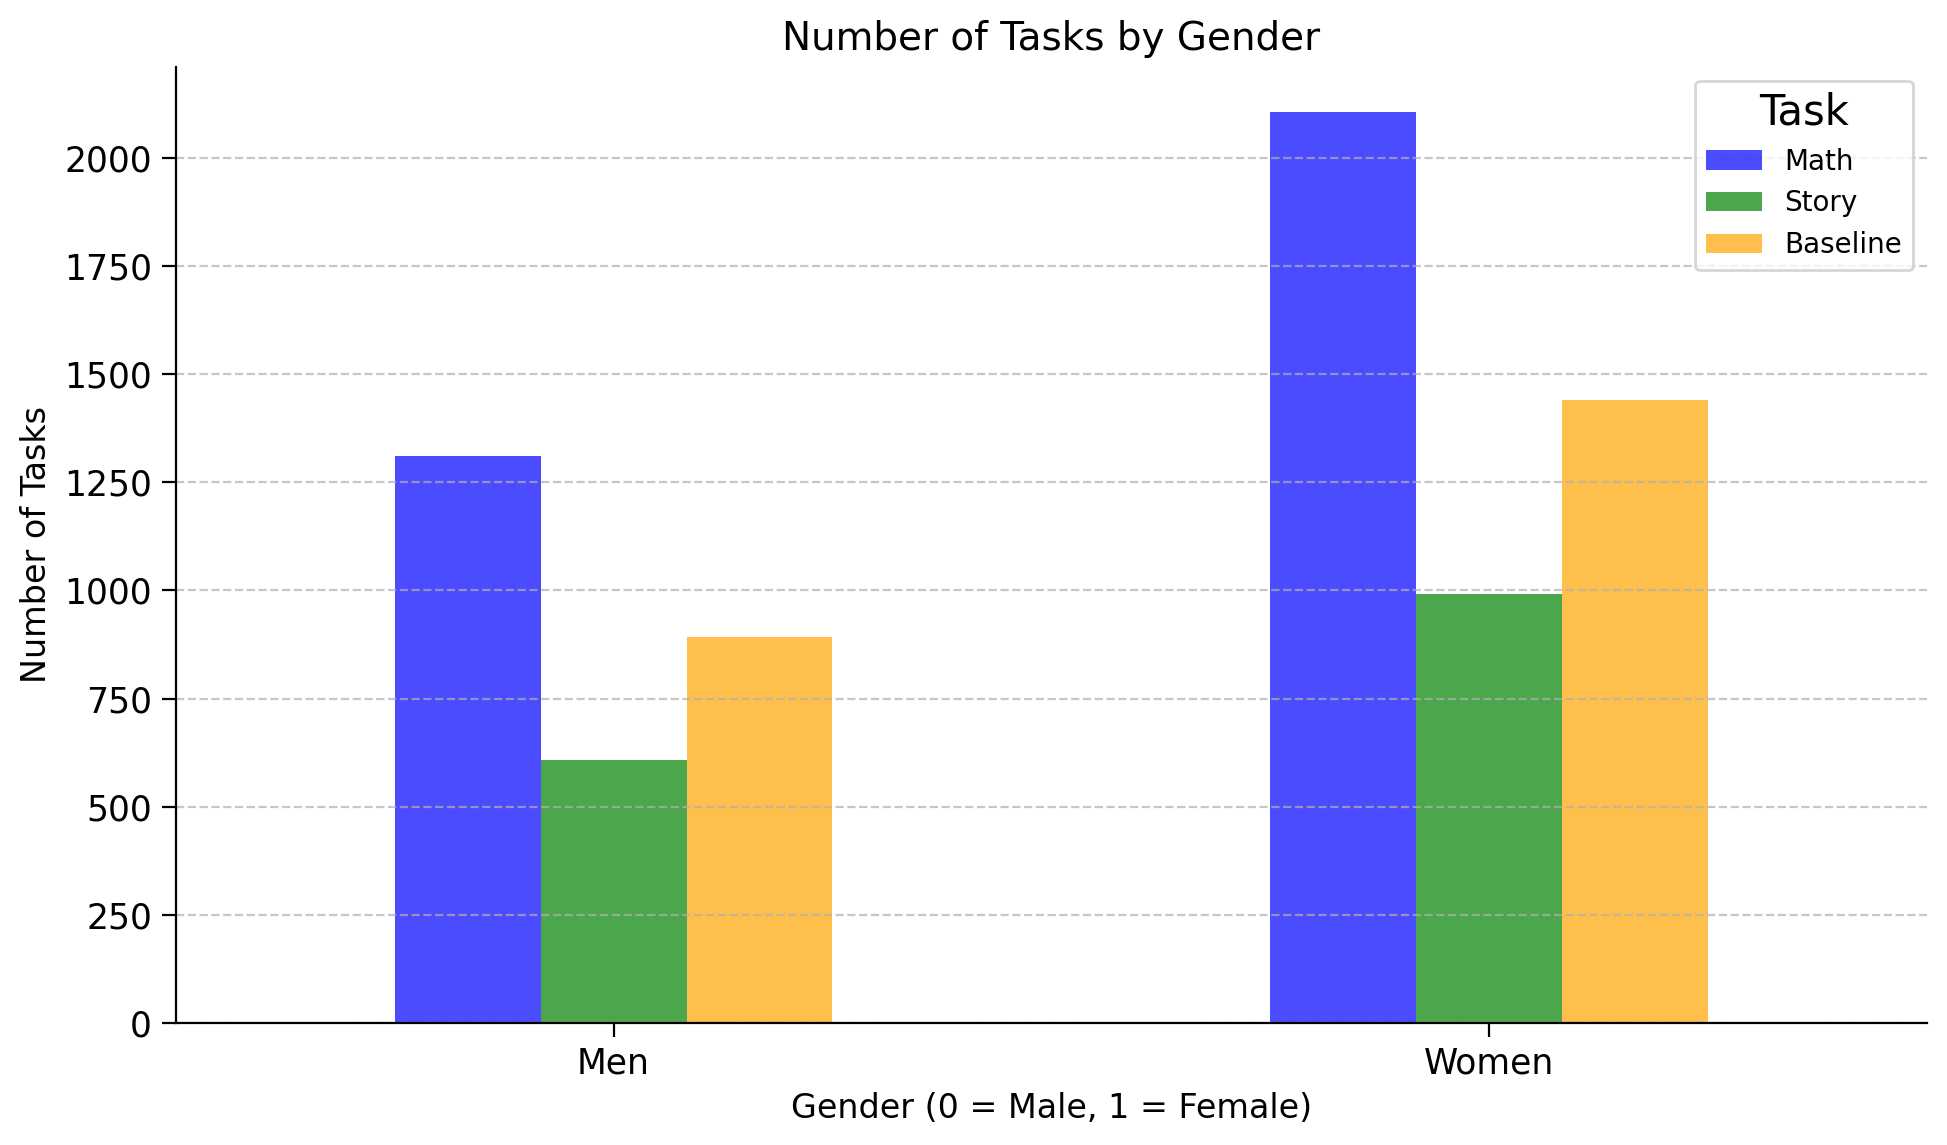

In [11]:
def load_data(my_exp, my_regions):

    HCP_data_frame = pd.read_csv('ddisc.csv')  # Load subject-level data
    steps = int(10 / TR + 0.5)  # 10 seconds converted to TR steps

    ts_list = []
    target_list = []
    Gender_list = []

    order = torch.randperm(100).numpy()  # Randomized order of subjects

    for i in order:  # Iterate over subjects
        for r in range(2):  # Iterate over runs

            # Load and normalize time series data
            data = load_single_timeseries(subject=subjects[i],
                                          experiment=my_exp,
                                          run=r,
                                          remove_mean=True)
            timeseries = (data - data.mean()) / data.std()

            # Load task EVs
            evs = load_evs(subject=subjects[i], experiment=my_exp, run=r)

            for c in range(2):  # Iterate over both conditions (MATH = 0, STORY = 1)
                for t in range(len(evs[c])):  # Iterate over blocks

                    # Split both tasks symmetrically into two halves
                    for split in range(2):  
                        start = evs[c][t][0] + split * math.floor(len(evs[c][t]) / 2)
                        end = start + 18  # Fixed block size: 18 frames

                        # Ensure indices are within bounds
                        if end <= timeseries.shape[1]:  # Check if end is within valid range
                            evs_index = np.arange(start, end)
                            if len(evs_index) == 18:  # Ensure block length consistency
                                ts_list.append(timeseries[my_regions, :][:, evs_index].T)
                                target_list.append(c)  # Condition label: 0 = MATH, 1 = STORY

                                # Gender label: 0 = Male, 1 = Female
                                gender = HCP_data_frame[HCP_data_frame['Subject_ID'] == int(subjects[i])]['Gender'].item()
                                Gender_list.append(1 if gender == 'F' else 0)

                    # Add baseline trials for both MATH and STORY conditions
                    baseline_start = evs[c][t][-1] + 1  # Start baseline immediately after task
                    evs_index = np.arange(baseline_start, baseline_start + 18)

                    # Ensure baseline is within bounds
                    if baseline_start + 18 < timeseries.shape[1]:  # Check if baseline fits in the data
                        ts_list.append(timeseries[my_regions, :][:, evs_index].T)
                        target_list.append(2)  # Label 2 for baseline (null condition)
                        Gender_list.append(Gender_list[-1])  # Reuse gender for the baseline
                        
    return (
        np.array(ts_list),       # Time series samples
        np.array(target_list),   # Task labels (0 = MATH, 1 = STORY, 2 = BASELINE)
        np.array(Gender_list)    # Gender labels
    )

experiment = 'LANGUAGE'
regions = [*range(360)]
label_type  = 'MS'
label = {}
#X, label['MS'], label['gender'] = load_data(experiment, regions)
#y = label[label_type]
ts_list, target_list, Gender_list = load_data(experiment, regions)

# Ensure consistent task representation
task_labels = {0: "Math", 1: "Story", 2: "Baseline"}

# Create DataFrame for analysis
df = pd.DataFrame({"Gender": Gender_list,
                   "Task": target_list})

# Count tasks by gender
task_counts = df.groupby(["Gender", "Task"]).size().unstack()

# Ensure all tasks are represented, even if counts are 0
task_counts = task_counts.reindex(columns=[0, 1, 2], fill_value=0)

# Create the bar chart with updated colors
task_counts.plot(
    kind="bar",
    color=["blue", "green", "orange"],  # Updated color scheme: Math, Story, Baseline
    alpha=0.7,
    figsize=(10, 6)
)

# Customize plot
plt.title("Number of Tasks by Gender", fontsize=14)
plt.ylabel("Number of Tasks", fontsize=12)
plt.xlabel("Gender (0 = Male, 1 = Female)", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Men", "Women"], rotation=0)
plt.legend([task_labels[0], task_labels[1], task_labels[2]], title="Task", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()



In [12]:
tam = [arr.shape[0] for arr in ts_list]

cont_math = 0
cont_story = 0
cont_h_math = 0
cont_m_math = 0
cont_h_story = 0
cont_m_story = 0

cont_baseline = 0
cont_h_baseline = 0
cont_m_baseline = 0

for i in range(len(tam)):
  if target_list[i] == 0:  # Math
    cont_math += 1
    if Gender_list[i] == 0:
      cont_h_math += 1
    else:
      cont_m_math += 1
  elif target_list[i] == 1:  # Story
    cont_story += 1
    if Gender_list[i] == 0:
      cont_h_story += 1
    else:
      cont_m_story += 1
  elif target_list[i] == 2:  # Baseline
    cont_baseline += 1
    if Gender_list[i] == 0:
      cont_h_baseline += 1
    else:
      cont_m_baseline += 1

print(cont_math)
print(cont_h_math)
print(cont_m_math)

print(cont_story)
print(cont_h_story)
print(cont_m_story)

3415
1310
2105
1600
608
992


In [13]:
# AUX funtion to build time-series dataset
def delayed_dataset(X, Y, delay, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    delay: integer indicating the delay between last time step in x and time step in y
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - (delay + hist_size)
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples, Y.shape[1]))

  for ind in range(n_samples):
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size + delay]
  return x, y



Total number of samples in ts_list: 7346
Shape of the first time series sample: (18, 360)
Shape of the last time series sample: (18, 360)
Unique shapes in ts_list: {(18, 360)}

Sample Corresponding Labels:
Sample 0: Task = 0, Gender = 1
Sample 1: Task = 0, Gender = 1
Sample 2: Task = 2, Gender = 1
Sample 3: Task = 0, Gender = 1
Sample 4: Task = 0, Gender = 1

Task Distribution:
Task 0 (Math): 3415 samples
Task 1 (Story): 1600 samples
Task 2 (Baseline): 2331 samples

Gender Distribution:
Gender 0 (Male): 2810 samples
Gender 1 (Female): 4536 samples

Visualizing Sample 0: Task = 0, Gender = 1


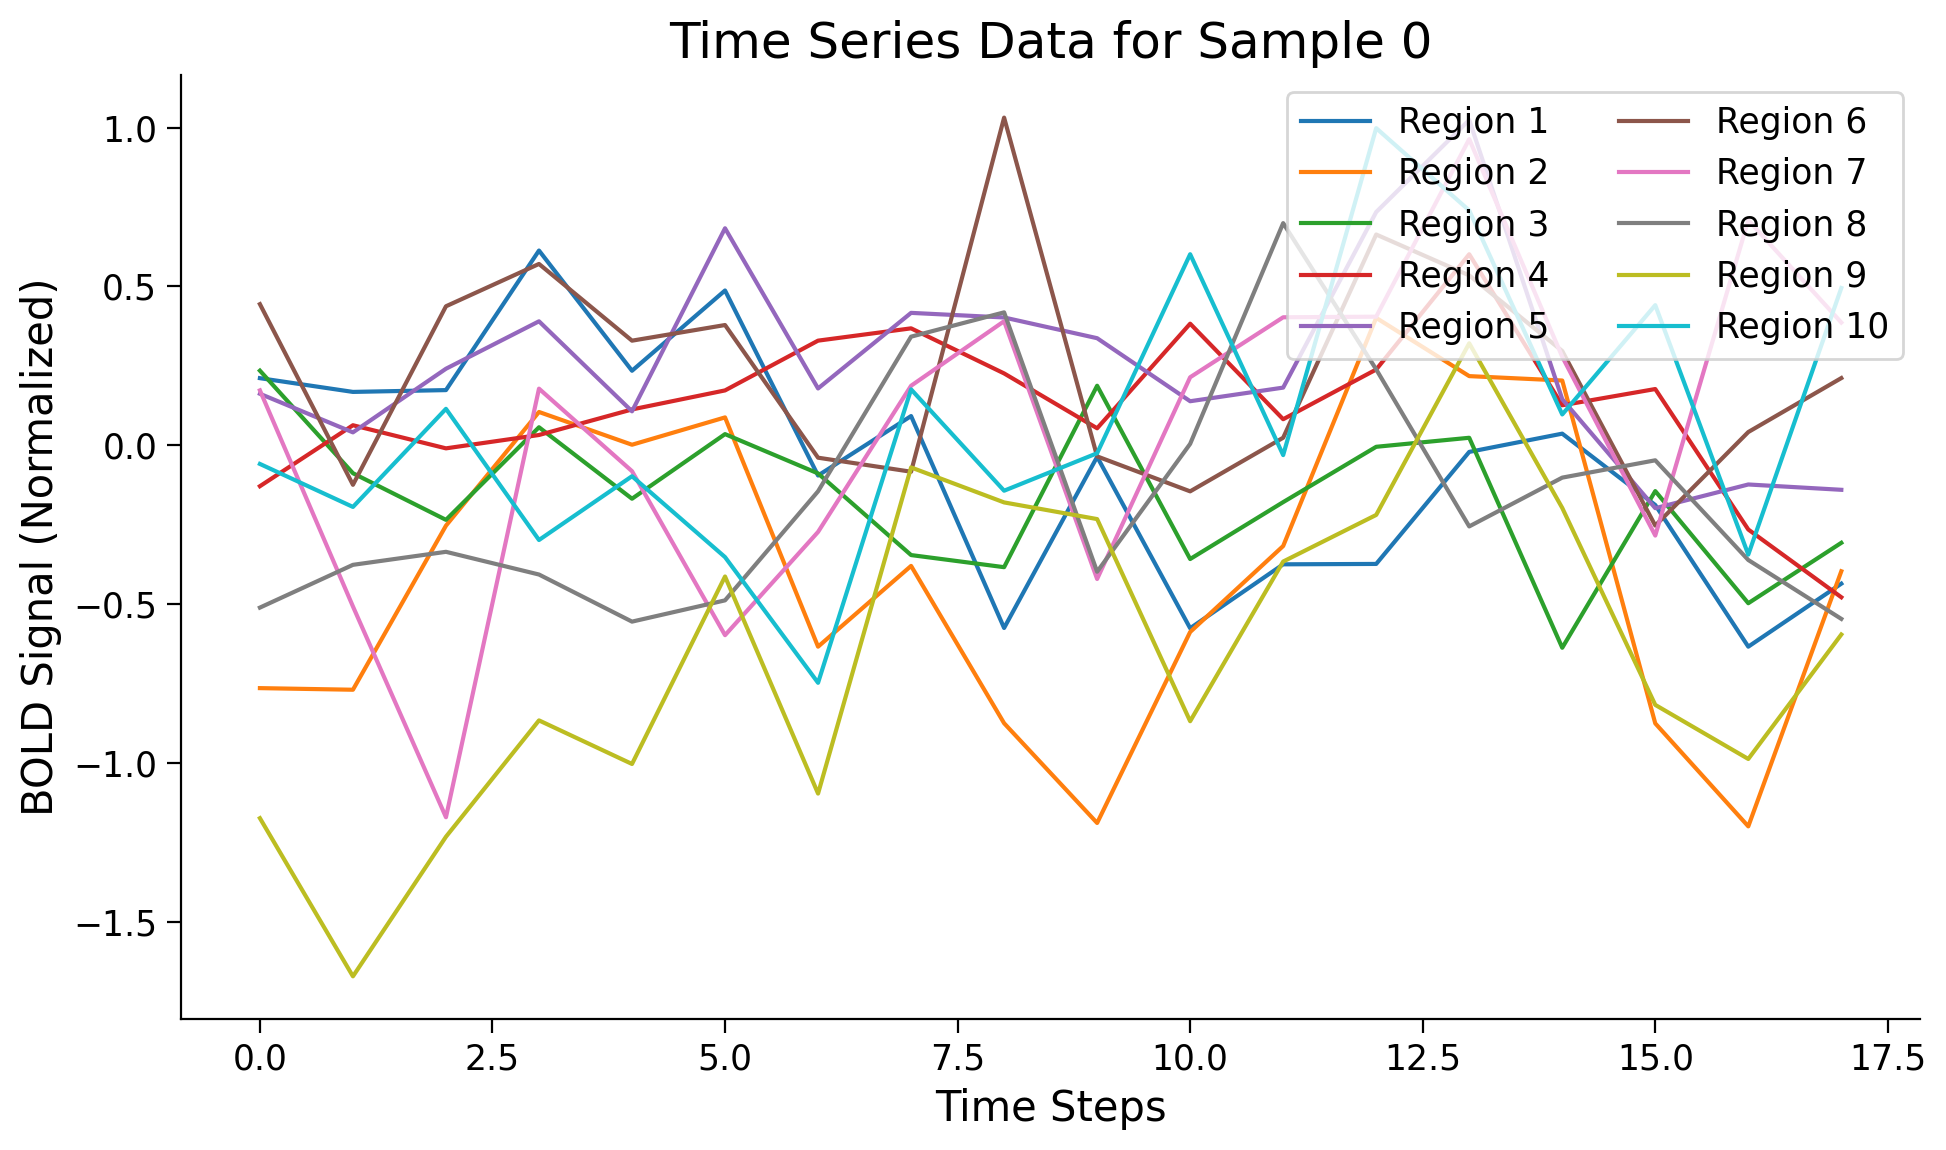

In [14]:
# Check overall structure of ts_list
print(f"Total number of samples in ts_list: {len(ts_list)}")

# Inspect the shape of each sample in ts_list
print(f"Shape of the first time series sample: {ts_list[0].shape}")
print(f"Shape of the last time series sample: {ts_list[-1].shape}")

# Verify all time series have consistent dimensions
shapes = [arr.shape for arr in ts_list]
print(f"Unique shapes in ts_list: {set(shapes)}")

# Check corresponding labels and genders
print("\nSample Corresponding Labels:")
for i in range(5):  # Display first 5 samples
    print(f"Sample {i}: Task = {target_list[i]}, Gender = {Gender_list[i]}")

# Summarize task distribution
unique_tasks, task_counts = np.unique(target_list, return_counts=True)
print("\nTask Distribution:")
for task, count in zip(unique_tasks, task_counts):
    task_name = "Math" if task == 0 else "Story" if task == 1 else "Baseline"
    print(f"Task {task} ({task_name}): {count} samples")

# Summarize gender distribution
unique_genders, gender_counts = np.unique(Gender_list, return_counts=True)
print("\nGender Distribution:")
for gender, count in zip(unique_genders, gender_counts):
    gender_name = "Male" if gender == 0 else "Female"
    print(f"Gender {gender} ({gender_name}): {count} samples")

# Visualize a single sample time series (first 10 regions)
sample_idx = 0  # Index of the sample to visualize
sample_data = ts_list[sample_idx]  # Shape: (time_steps, n_regions)

print(f"\nVisualizing Sample {sample_idx}: Task = {target_list[sample_idx]}, Gender = {Gender_list[sample_idx]}")
time_steps, n_regions = sample_data.shape

# Plot time series for the first 10 brain regions
plt.figure(figsize=(10, 6))
for region in range(min(10, n_regions)):  # Plot only first 10 regions
    plt.plot(range(time_steps), sample_data[:, region], label=f"Region {region + 1}")

plt.title(f"Time Series Data for Sample {sample_idx}")
plt.xlabel("Time Steps")
plt.ylabel("BOLD Signal (Normalized)")
plt.legend(loc='upper right', fontsize="small", ncol=2)
plt.show()


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(ts_list, target_list, test_size=0.10)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(6611, 18, 360)
(735, 18, 360)
(6611,)
(735,)


In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, LeakyReLU, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Convert ts_list and target_list to NumPy arrays
X = np.array(ts_list)  # Shape: (n_samples, time_steps, n_regions)
y = np.array(target_list)

# One-hot encode the target labels
y_one_hot = to_categorical(y, num_classes=3)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y_one_hot, test_size=0.10, random_state=42)

# Build the LSTM model
rnn_model = Sequential()
rnn_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input shape: (time_steps, n_regions)
rnn_model.add(LSTM(units=64, return_sequences=True))  # First LSTM layer
rnn_model.add(Dropout(0.3))  # Dropout for regularization
rnn_model.add(LSTM(units=32))  # Second LSTM layer
rnn_model.add(Dense(16))  # Fully connected layer
rnn_model.add(LeakyReLU())  # Activation function
rnn_model.add(Dense(3, activation='softmax'))  # Output layer with softmax for 3 classes

# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
rnn_model.summary()

# Train the model
history = rnn_model.fit(X_train, Y_train, validation_split=0.1, epochs=50, batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
Y_pred = np.argmax(rnn_model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test, axis=1)
print(classification_report(Y_true, Y_pred, target_names=['Math', 'Story', 'Baseline']))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 18, 64)            108800    
                                                                 
 dropout_1 (Dropout)         (None, 18, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 121795 (475.76 KB)
Trainable params: 121

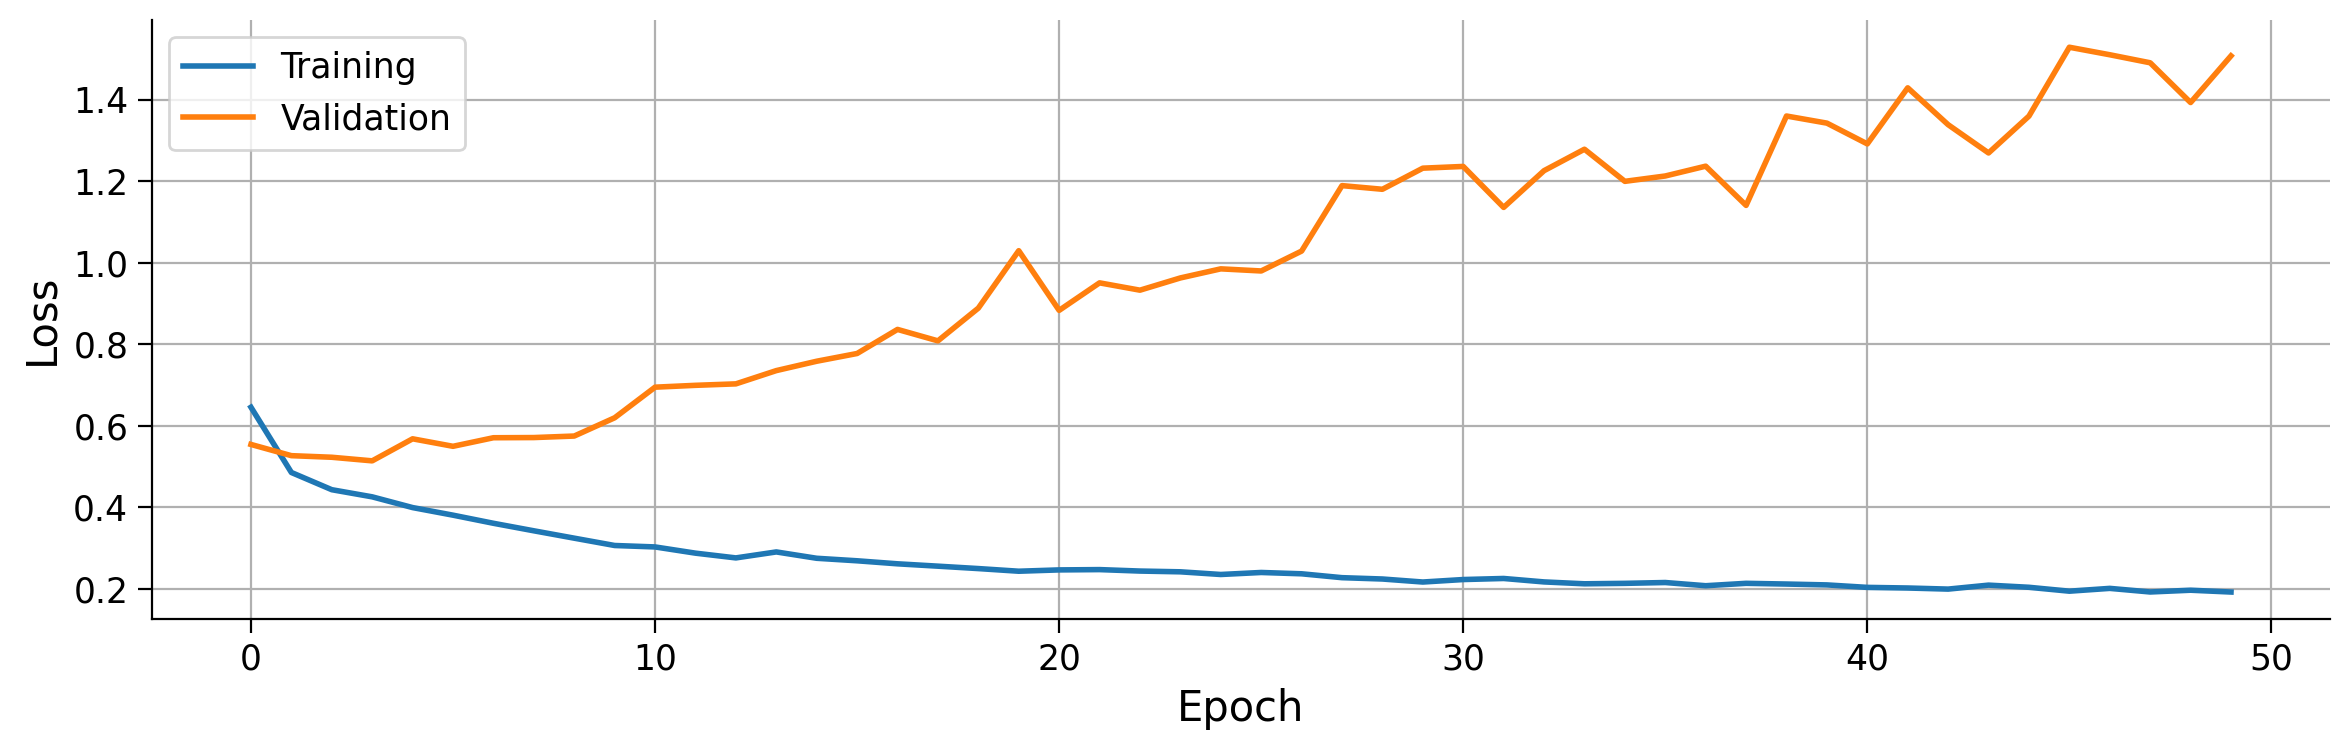

In [18]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [19]:
# Predict on training and test sets
Y_train_hat = np.round(rnn_model.predict(X_train))
Y_test_hat = np.round(rnn_model.predict(X_test))


23/23 [==============================] - 0s 4ms/step


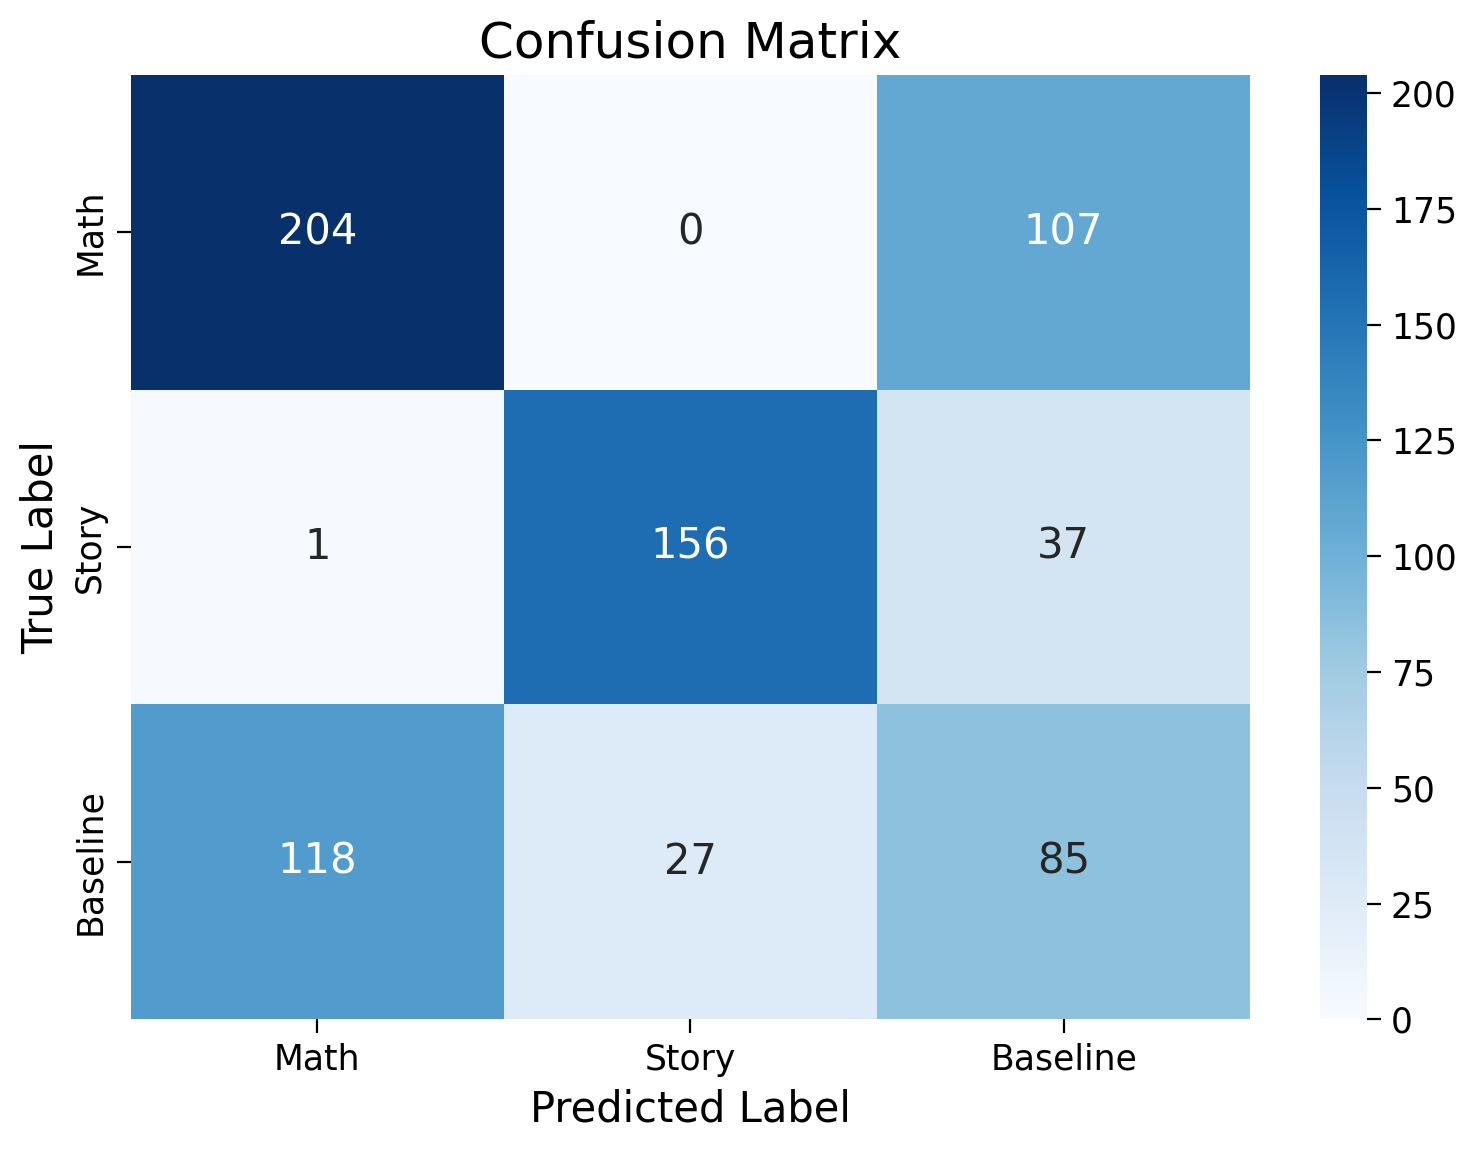

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Math', 'Story', 'Baseline'], yticklabels=['Math', 'Story', 'Baseline'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
def get_gradient(model, inputs):
    """Compute the gradient of the model's predictions with respect to the input."""
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    inputs = tf.expand_dims(inputs, axis=0)  # Add batch dimension
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    gradient = tape.gradient(predictions, inputs)
    return gradient.numpy()

# Initialize accumulators for gradients
gradient_math = np.zeros_like(X_test[0])
gradient_story = np.zeros_like(X_test[0])

# Accumulate gradients for each class
for i in range(len(X_test)):
    gradient = get_gradient(rnn_model, X_test[i])
    if Y_test[i][0] == 1:  # Math class
        gradient_math += gradient
    elif Y_test[i][1] == 1:  # Story class
        gradient_story += gradient

# Average gradients across all samples for each task
gradient_math /= np.sum(Y_test[:, 0])
gradient_story /= np.sum(Y_test[:, 1])


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1051fd2b0>>
Traceback (most recent call last):
  File "/Users/alejandroalva/anaconda3/envs/mestria/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 791, in _clean_thread_parent_frames
    for stream in [self._stdout, self._stderr]:
KeyboardInterrupt: 


In [ ]:
# Sum gradients over time for each ROI
roi_grad_math = gradient_math.sum(axis=0)  # Shape: (n_regions,)
roi_grad_story = gradient_story.sum(axis=0)  # Shape: (n_regions,)

# Prepare DataFrame with ROI information
df_roi = pd.DataFrame({
    'Region': region_info['name'],  # ROI names
    'Network': region_info['network'],  # Network associated with the ROI
    'Hemisphere': region_info['hemi'],  # Hemisphere (Right/Left)
    'Math Gradient': roi_grad_math,
    'Story Gradient': roi_grad_story
})


ValueError: Per-column arrays must each be 1-dimensional

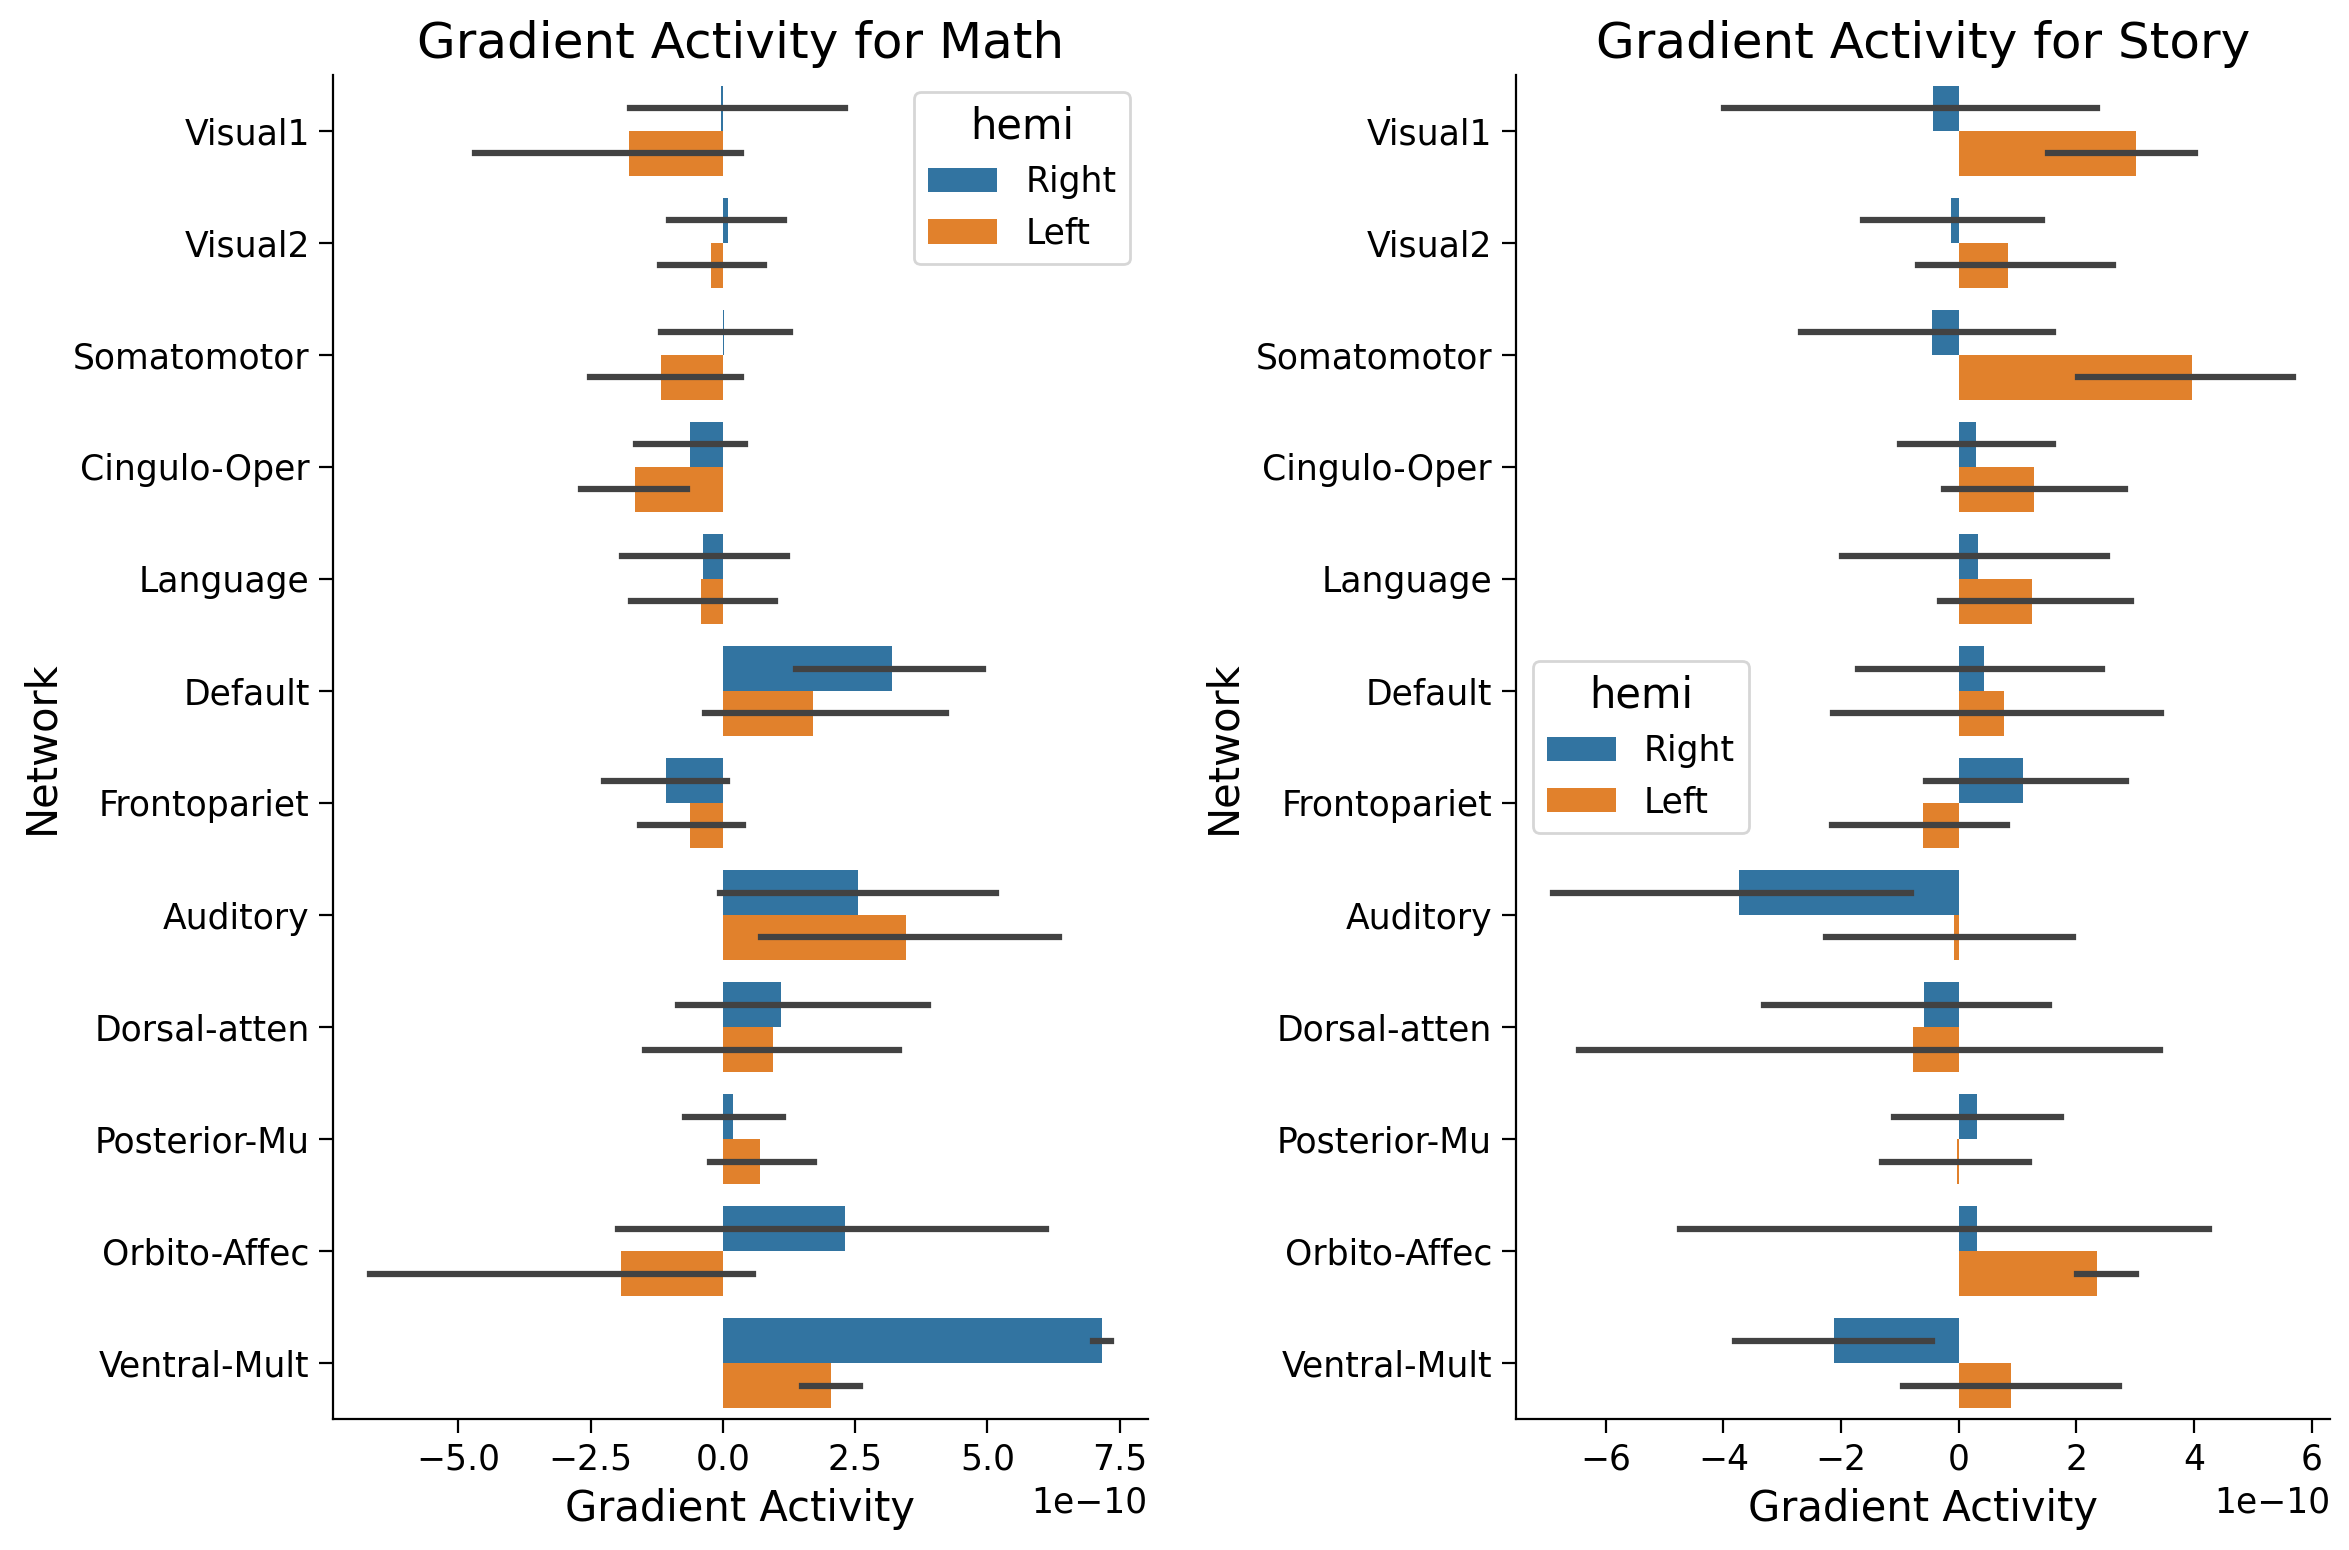

In [25]:
# Prepare DataFrame for gradient visualization
gradient_sum_math = gradient_math.sum(axis=(0, 1))  # Sum across time and regions
gradient_sum_story = gradient_story.sum(axis=(0, 1))

df = pd.DataFrame({
    'math_activity': gradient_sum_math,
    'story_activity': gradient_sum_story,
    'network': region_info['network'],
    'hemi': region_info['hemi']
})

# Plot gradients as bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(y='network', x='math_activity', data=df, hue='hemi', ax=ax1)
ax1.set_title("Gradient Activity for Math")
ax1.set_xlabel("Gradient Activity")
ax1.set_ylabel("Network")

sns.barplot(y='network', x='story_activity', data=df, hue='hemi', ax=ax2)
ax2.set_title("Gradient Activity for Story")
ax2.set_xlabel("Gradient Activity")
ax2.set_ylabel("Network")

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by Math Gradient for clarity
df_roi_sorted = df_roi.sort_values(by='Math Gradient', ascending=False)

# Plot gradients for Math and Story tasks
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Math Gradient', y='Region', data=df_roi_sorted, hue='Hemisphere', dodge=False, palette="viridis", ax=ax)
ax.set_title("ROI Gradients for Math Task")
ax.set_xlabel("Gradient Value")
ax.set_ylabel("Region of Interest (ROI)")
plt.tight_layout()
plt.show()


In [26]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [28]:
pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.1 MB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 22.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00
  Created wheel for lxml: filename=lxml-5.3.0-cp38-cp38-macosx_11_0_arm64.whl size=1484261 sha256=ac66b3bdfa8eb3c6ecc4b94ce8898ac9cbc24831a66b8b5162eb8dbc2b023f1d
  Stored in directory: /Users/alejandroalva/Library/Caches/pip/wheels/37/19/50/80ff9642d74365e416a0b370a5784afd3167f4e1182644c30b
Successfully built lxml
Note: you may need to restart the kernel to use updated packages.


In [27]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = 1500*contraste_grad[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

ModuleNotFoundError: No module named 'nilearn'

In [47]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = 1500*contraste_grad[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=20)

In [42]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = gradient_sum_math[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=0.004)

In [43]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = gradient_sum_math[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=0.004)